## Experience of classification with only with a few features

In this experience a random forest classifier will be trained only on 4 features :
- spectral flatness
- spectral roll-off 0.9
- EEGv_max 2
- EMGv log

All the mice will be uses for this experience, only the data of the third day are kept and one mouse of each breed will be used as the test set. (the train set and the test set are the same as the one from the classification experience)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
import os
from imblearn.ensemble import BalancedRandomForestClassifier

import sys
sys.path.append('../Library')

import breedManip as breedManip
import dataProcessing as dataProcessing
import breeds as breeds
import splitData as splitData

import importlib
importlib.reload(dataProcessing)
importlib.reload(splitData)

import warnings
warnings.filterwarnings('ignore')

2023-07-27 11:00:19.295445: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 11:00:19.367508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-27 11:00:20.529823: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# read the df_train from pickle
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

# read the df_test from pickle
with open('/home/magali.egger/shared-projects/mice_UNIL/Data/df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)

In [3]:
# keep only the spectral_flatness, spectral_roll-off_0.9, EEGv_max 2 and EMGv log
df_train = df_train[['spectral_rolloff_0.9', 'spectral_flatness', 'EEGv_max2', 'EMGv_log', 'EMGv_max50','rawState', 'state']]
df_test = df_test[['spectral_rolloff_0.9', 'spectral_flatness', 'EEGv_max2' , 'EMGv_log', 'EMGv_max50','rawState', 'state']]
df_train.head()

,spectral_rolloff_0.9,spectral_flatness,EEGv_max2,EMGv_log,EMGv_max50,rawState,state
42314,11.00,0.036518,3.980820e-09,-21.730842,8.146028e-09,w,w
42315,17.25,0.062002,2.985767e-09,-21.180370,8.146028e-09,w,w
42316,34.00,0.089685,2.640900e-09,-21.551424,8.146028e-09,w,w
42317,32.50,0.083383,3.147568e-09,-18.494858,9.285070e-09,w,w
42318,0.50,0.011221,3.599005e-09,-18.772852,9.285070e-09,w,w


In [4]:
df_train = dataProcessing.rebalance_state(df_train, 13)
x_train, x_test, y_train, y_test, le = splitData.encode_scale_data(df_train, df_test, 13, cat_matrix=True)

#### Training of the random forest classifier

In [5]:
rfc = BalancedRandomForestClassifier(random_state=23, n_jobs=-1, class_weight='balanced')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

[[238260  28177  12983]
 [  5570  28255   5948]
 [ 55612  25844 371285]]
              precision    recall  f1-score   support

           n       0.80      0.85      0.82    279420
           r       0.34      0.71      0.46     39773
           w       0.95      0.82      0.88    452741

    accuracy                           0.83    771934
   macro avg       0.70      0.79      0.72    771934
weighted avg       0.86      0.83      0.84    771934



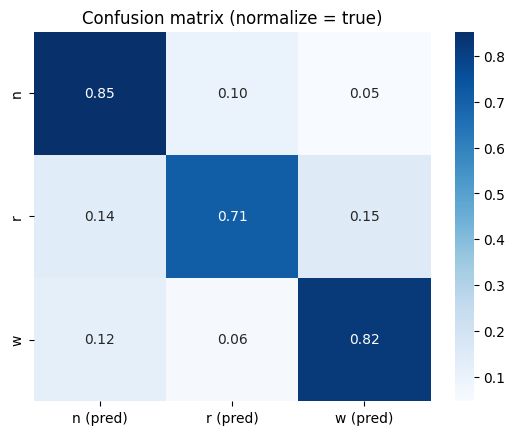

In [6]:

from sklearn.metrics import classification_report, confusion_matrix
pred = np.argmax(y_pred, axis=1)
test = np.argmax(y_test, axis=1)

# plot the confusion matrix between predictions of the model and real values

cm = np.array(confusion_matrix(test, pred))
print(cm)

cm = np.array(confusion_matrix(test, pred, normalize='true')) # normalize = 'true' or 'pred'
confusion = pd.DataFrame(cm, index=le.classes_, columns=le.classes_ + ' (pred)')


print(classification_report(test, pred, target_names=le.classes_, zero_division=0))

sns.heatmap(confusion, annot=True, cmap="Blues", fmt='.2f')
plt.title(f'Confusion matrix (normalize = true)')
plt.show()